In [1]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SequentialSampler, Subset
from utils import get_lags, get_average, TrainHelper, Window, CoreDataset, evaluate_on_test, init_weights, save_obj, load_obj

In [3]:
full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0], parse_dates=True)

In [4]:
class GRUNet(nn.Module):
    def __init__(self, lags, hidden_size):
        super(GRUNet, self).__init__()
        self.lags = lags
        self.hidden_size = hidden_size
        
        # input_size should match that in forward method
        self.gru = nn.GRU(input_size=3, hidden_size=hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 3)
        
    def forward(self, x):
        # input to lstm layer is (seq_len, batch, input_size)
        x, hidden = self.gru(x.view(self.lags, 1, 3))
        # we only care about the output of the hidden
        hidden = F.relu(self.fc1(hidden))
        hidden = self.fc2(hidden)
        return hidden

In [5]:
trainer = TrainHelper(percent = 0.99, manual = 5000, print_every=1000)

PATH = "./GRU One Layer/"

def train_times(times, trainer, net, criterion, optimizer, window):
    
    losses = []

    # train ten times, find best loss
    for i in range(times):
        net.apply(init_weights)
        print("Training %d time" % i)
        loss = trainer.train_window(net, criterion, optimizer, window)
        torch.save(net.state_dict(), PATH + "lag" + str(net.lags) + "hidden" + str(net.hidden_size) + "_" + str(i) + ".pt")
        losses.append(loss)
        
    return losses

In [6]:
length = len(full.loc["1948-01-01":])
val_start = round(length * 0.8)
test_start = round(length * 0.9)    

In [8]:
losses = {}

In [16]:
hiddens = [5, 10]

for lags in range(1, 8):
    coredata = CoreDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

    # subtract by lags to ensure same training sets
    trainset = Subset(coredata, [i for i in range(val_start - 1 - lags)])
    valset = Subset(coredata, [i for i in range(val_start - lags, test_start - 1 - lags)])

    trainloader = DataLoader(trainset, batch_size=1, shuffle=False, sampler=SequentialSampler(trainset))
    validationloader = DataLoader(valset, batch_size=1, shuffle=False, sampler=SequentialSampler(valset))

    window = Window(trainloader, validationloader)
    
    for hidden_size in hiddens:
        print("Training new net, %d lags %d hidden" % (lags, hidden_size))

        net = GRUNet(lags=lags, hidden_size=hidden_size)
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=0.001)
        loss = train_times(10, trainer, net, criterion, optimizer, window)
        print(loss)
        losses[str(lags) + "-" + str(hidden_size)] = loss
    

Training new net, 1 lags 5 hidden
Training 0 time
[epoch: 1] train loss: 0.944, val loss: 1.346
Finished window, trained for 80 epochs, loss: 0.053
Training 1 time
[epoch: 1] train loss: 0.994, val loss: 0.923
Finished window, trained for 21 epochs, loss: 0.485
Training 2 time
[epoch: 1] train loss: 0.932, val loss: 1.114
Finished window, trained for 73 epochs, loss: 0.078
Training 3 time
[epoch: 1] train loss: 1.093, val loss: 0.910
Finished window, trained for 31 epochs, loss: 0.134
Training 4 time
[epoch: 1] train loss: 1.292, val loss: 1.064
Finished window, trained for 51 epochs, loss: 0.111
Training 5 time
[epoch: 1] train loss: 0.829, val loss: 0.845
Finished window, trained for 69 epochs, loss: 0.058
Training 6 time
[epoch: 1] train loss: 1.121, val loss: 0.616
Finished window, trained for 31 epochs, loss: 0.075
Training 7 time
[epoch: 1] train loss: 1.124, val loss: 0.654
Finished window, trained for 38 epochs, loss: 0.069
Training 8 time
[epoch: 1] train loss: 1.042, val loss

KeyboardInterrupt: 

In [20]:
for k, v in losses.items():
    print(k)
    best_net_index = np.argmin(v)
    print("%.4f" % v[best_net_index])
    print("(%.4f)" % get_average(v))

1-5
0.0530
(0.1216)
1-10
0.0669
(0.0914)
2-5
0.1099
(0.1785)
2-10
0.0753
(0.1310)
3-5
0.1317
(0.2052)
3-10
0.1378
(0.1711)
4-5
0.1792
(0.2470)
4-10
0.1771
(0.2284)
5-5
0.1713
(0.2706)
5-10
0.2396
(0.3157)
6-5
0.2629
(0.3701)
6-10
0.1412
(0.2709)
7-5
0.1768
(0.2985)
7-10
0.2430
(0.4472)


In [18]:
best_loss_5 = []
avg_loss_5 = []
best_loss_10 = []
avg_loss_10 = []

for k, v in losses.items():
    if k.split("-")[1] == str(5):
        best_net_index = np.argmin(v)
        best_loss_5.append(v[best_net_index])
        avg_loss_5.append(get_average(v))
    if k.split("-")[1] == str(10):
        best_net_index = np.argmin(v)
        best_loss_10.append(v[best_net_index])
        avg_loss_10.append(get_average(v))
    
# best_loss = []
# avg_loss = []

# for i in range(len(best_loss_12)):
#     best_loss.append((best_loss_12[i] + best_loss_24[i]) / 2)
#     avg_loss.append((avg_loss_12[i] + avg_loss_24[i]) / 2)


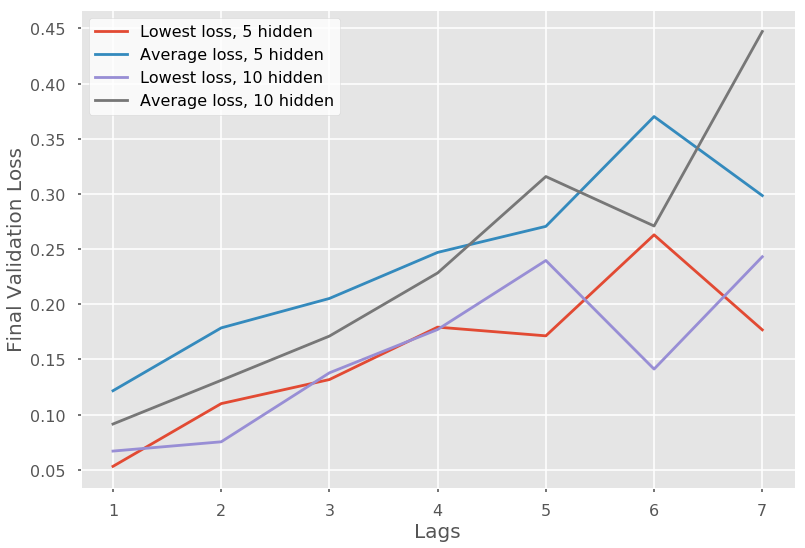

In [21]:
from matplotlib import style

style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

# plt.figure(figsize=(15,10))

plt.plot([i for i in range(1, len(best_loss_5) + 1)], best_loss_5)
plt.plot([i for i in range(1, len(best_loss_5) + 1)], avg_loss_5)
plt.plot([i for i in range(1, len(best_loss_5) + 1)], best_loss_10)
plt.plot([i for i in range(1, len(best_loss_5) + 1)], avg_loss_10)

plt.xticks([1, 2, 3, 4, 5, 6, 7])

plt.legend(("Lowest loss, 5 hidden", "Average loss, 5 hidden", "Lowest loss, 10 hidden", "Average loss, 10 hidden"), facecolor="white")
plt.xlabel("Lags", fontsize=20)
plt.ylabel("Final Validation Loss", fontsize=20)
plt.savefig('../Figs/lags_gru_core.png', bbox_inches='tight')

In [17]:
save_obj(losses, "GRU_Core_One_Layer")

# Forecasts

In [11]:
from utils import count_parameters

In [7]:
losses = load_obj("GRU_Core_One_Layer")

In [8]:
# best model?
lowest = 100000000

for k, v in losses.items():
    best_index = np.argmin(v)
    best_loss = v[best_index]
    if best_loss < lowest:
        lowest = best_loss
        lowest_key = k
        lowest_index = best_index
        
print(lowest)
print(lowest_key)
print(lowest_index)

0.05303510734902731
1-5
0


In [7]:
lags = 1

testdata = CoreDataset(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"])

testset = Subset(testdata, [i for i in range(test_start, length - lags)])

testloader = DataLoader(testset, batch_size=1, shuffle=False,
                        sampler=SequentialSampler(testset))

In [8]:
criterion = nn.MSELoss()

net = GRUNet(lags, hidden_size=5)
net.load_state_dict(torch.load("GRU One Layer/lag1hidden5_0.pt"))

0.010518973334997316

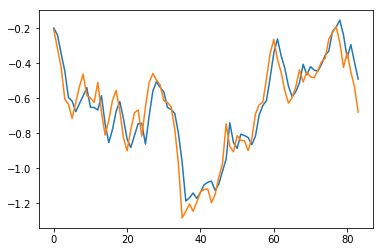

In [9]:
evaluate_on_test(testloader, net, criterion)

In [12]:
count_parameters(net)

198

# Multi-step

In [13]:
from utils import CoreDatasetMulti

In [14]:
steps = 3

multitestdata = CoreDatasetMulti(full, lags=lags, series=["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"], steps=steps)

multitestset = Subset(multitestdata, [i for i in range(test_start, length - lags - steps)])

multitestloader = DataLoader(multitestset, batch_size=1, shuffle=False,
                        sampler=SequentialSampler(multitestset))

0.05264967710159167

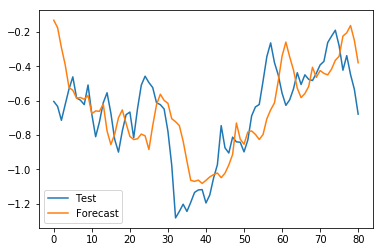

In [15]:
net.eval()
y_pred = []
y_act = []
running_test_loss = []

for i, data in enumerate(multitestloader):
    y, X = data
    y, X = y.float(), X.float()

    with torch.no_grad():
        forecast_1 = net(X)
        forecast_2 = net(forecast_1)
        forecast_3 = net(forecast_2)
        
        loss = criterion(y, forecast_3)
        running_test_loss.append(loss.item())
        
        y_pred.append(forecast_3.squeeze().numpy()[0])
        y_act.append(y.squeeze().numpy()[0])

plt.plot(y_act)
plt.plot(y_pred)
plt.legend(("Test", "Forecast"), facecolor="white")
        
get_average(running_test_loss)